In [2]:
import pandas as pd
import unicodecsv as csv
from __future__ import print_function
import untangle
import xmltodict

import matplotlib
import seaborn as sns
%matplotlib inline
#import lxml 

import warnings
warnings.filterwarnings("ignore")

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
from bs4 import BeautifulSoup

with open('./2015EdTech/users.xml', 'r') as f:
    d = f.read()
    
y=BeautifulSoup(d)
print(len(y.records.findAll('user_id')))
#print(y.records.findAll('user_id'))
#print(y.records.findAll('name'))
#print(y.user_id.string)

118


In [4]:
uid = [str(x.contents[0]) for x in y.records.findAll('user_id')]
asks = [int(x.contents[0]) for x in y.records.findAll('asks')]
ans = [int(x.contents[0]) for x in y.records.findAll('answers')]
p = [int(x.contents[0]) for x in y.records.findAll('posts')]
v = [int(x.contents[0]) for x in y.records.findAll('views')]
d = [int(x.contents[0]) for x in y.records.findAll('days')]

In [5]:
zipped = zip(uid, asks, ans, p, v, d)

In [6]:
df = pd.DataFrame(zipped, columns=['uid', 'asks', 'answers', 'posts', 'views', 'days'])
print(type(df.answers[0]))
print(df.head())

<type 'numpy.int64'>
         uid  asks  answers  posts  views  days
0  Student71     0        0    132    324    56
1     Guest1     0        0     14      4     7
2  Student14     0        0      0      0     0
3  Student92     2        0     17    106    26
4     Guest2     0        0      9     10     2


In [7]:
def get_type(x):
    if 'guest' in str(x).lower():
        return 'guest'
    elif 'teacher' in str(x).lower():
        return 'teacher'
    else:
        return 'student'

df['type'] = df.uid.apply(lambda x: get_type(x))
print(df.head())

         uid  asks  answers  posts  views  days     type
0  Student71     0        0    132    324    56  student
1     Guest1     0        0     14      4     7    guest
2  Student14     0        0      0      0     0  student
3  Student92     2        0     17    106    26  student
4     Guest2     0        0      9     10     2    guest


In [22]:
#add gradebook results into this dataset
grades = pd.read_csv('./2015EdTech/gradebook-gtc-f1f6-435f-518b-a7e9-c0aa24923e82-3_30_16.csv')
grades.columns

Index([u'Student ID', u'Student Name', u'Personal Statement [2]',
       u'Assignment 1 [2]', u'Assignment 2 [2]', u'Mini-Proposal [2]',
       u'Personal Question [2]', u'Proposal -- First Draft [2]',
       u'Proposal -- Final Draft [2]', u'Progress Report [1]', u'Trailer [2]',
       u'Final Project [2]', u'Project Paper [2]', u'Project Presentation [2]',
       u'Final Grade [23]'],
      dtype='object')

In [24]:
#combine df with grades
df_2 = pd.merge(df, grades, how='outer', left_on='uid', right_on='Student ID',
                     suffixes=('_uid', '_g'))

df_2.head()

,uid,asks,answers,posts,views,days,type,Student ID,Student Name,Personal Statement [2],...,Mini-Proposal [2],Personal Question [2],Proposal -- First Draft [2],Proposal -- Final Draft [2],Progress Report [1],Trailer [2],Final Project [2],Project Paper [2],Project Presentation [2],Final Grade [23]
0,Student71,0,0,132,324,56,student,Student71,Student71,1,...,1,2,2,2,1,1,2,2,2,0.782609
1,Guest1,0,0,14,4,7,guest,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Student14,0,0,0,0,0,student,Student14,Student14,1,...,0,0,1,1,1,1,2,1,NaN,0.347826
3,Student14,0,2,25,71,29,student,Student14,Student14,1,...,0,0,1,1,1,1,2,1,NaN,0.347826
4,Student92,2,0,17,106,26,student,Student92,Student92,1,...,1,1,1,1,1,1,1,1,1,0.521739


In [126]:
#create buckets for grades
#dfs_2.ix[:, 'Final Grade [23]'].describe()
def get_grade_bucket(x):
    if (x < .70):
        return 'd'  
    elif (x >= .70) & (x < .80):
        return 'c'    
    elif (x >= .80) & (x < .90):
        return 'b'
    elif (x >= .90):
        return 'a'

#dfs_2.ix[:, 'Final Grade [23]'].apply(lambda x: print(get_grade_bucket(x)))
df_2.ix[:, 'grade_bucket'] = df_2.ix[:, 'Final Grade [23]'].apply(lambda x: get_grade_bucket(x))
df_2.ix[:, ['Final Grade [23]', 'grade_bucket']].head()

,Final Grade [23],grade_bucket
0,0.782609,c
1,NaN,None
2,0.347826,d
3,0.347826,d
4,0.521739,d


In [130]:
df_2.head()

,uid,asks,answers,posts,views,days,type,Student ID,Student Name,Personal Statement [2],...,Personal Question [2],Proposal -- First Draft [2],Proposal -- Final Draft [2],Progress Report [1],Trailer [2],Final Project [2],Project Paper [2],Project Presentation [2],Final Grade [23],grade_bucket
0,Student71,0,0,132,324,56,student,Student71,Student71,1,...,2,2,2,1,1,2,2,2,0.782609,c
1,Guest1,0,0,14,4,7,guest,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,Student14,0,0,0,0,0,student,Student14,Student14,1,...,0,1,1,1,1,2,1,NaN,0.347826,d
3,Student14,0,2,25,71,29,student,Student14,Student14,1,...,0,1,1,1,1,2,1,NaN,0.347826,d
4,Student92,2,0,17,106,26,student,Student92,Student92,1,...,1,1,1,1,1,1,1,1,0.521739,d


In [127]:
#output to csv file
df_2.to_csv('users_EduTech_cleaned.csv')

In [132]:
df_students = df_2[(df_2.type != 'teacher') & (df_2.type != 'guest')]
len(df_students)

101

In [133]:
df_students.ix[:, ['uid', 'asks', 'answers', 'posts', 'views', 
                   'days', 'Final Grade [23]']].describe()

,asks,answers,posts,views,days,Final Grade [23]
count,101.000000,101.000000,101.000000,101.000000,101.000000,96.000000
mean,1.415842,0.544554,58.504950,221.861386,50.475248,0.670290
std,1.686816,1.091098,56.817009,108.788237,16.735946,0.147363
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.347826
25%,0.000000,0.000000,25.000000,113.000000,39.000000,0.565217
50%,1.000000,0.000000,43.000000,225.000000,53.000000,0.652174
75%,2.000000,1.000000,74.000000,330.000000,64.000000,0.782609
max,7.000000,6.000000,404.000000,346.000000,72.000000,1.000000


In [134]:
dfs = df_students.ix[:, ['uid', 'asks', 'answers', 'posts', 'views', 
                         'days', 'type', 'Final Grade [23]', 'grade_bucket']]

In [135]:
dfs[dfs.isnull()].count()

uid                 0
asks                0
answers             0
posts               0
views               0
days                0
type                0
Final Grade [23]    0
grade_bucket        0
dtype: int64

In [136]:
#df_students.dtypes
print('maximum values \n', dfs.max())
print('average values \n', dfs.mean())


maximum values 
 uid                 Student99
asks                        7
answers                     6
posts                     404
views                     346
days                       72
type                  student
Final Grade [23]            1
grade_bucket                d
dtype: object
average values 
 asks                  1.415842
answers               0.544554
posts                58.504950
views               221.861386
days                 50.475248
Final Grade [23]      0.670290
dtype: float64


In [137]:
#check for outliers
dfs[dfs.posts > 200]

,uid,asks,answers,posts,views,days,type,Final Grade [23],grade_bucket
10,Student13,4,0,202,156,49,student,0.695652,d
15,Student55,5,1,215,209,59,student,0.739130,c
20,Student34,3,6,404,340,71,student,0.478261,d


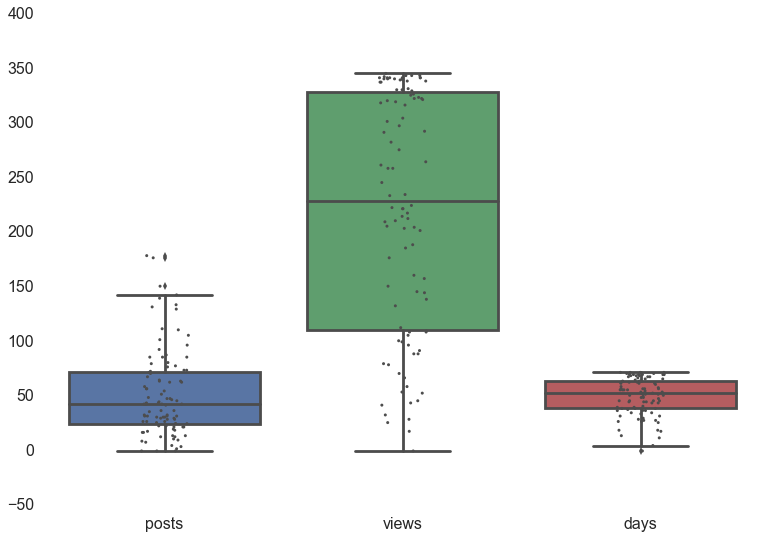

In [138]:
# Draw a nested boxplot to show bills by day and sex
# Plot the orbital period with horizontal boxes
ax = sns.boxplot(data=dfs[dfs.posts < 200].ix[:, ['posts', 'views', 'days']])
sns.stripplot(data=dfs[dfs.posts < 200].ix[:, ['posts', 'views', 'days']],
               jitter=True, size=3, color=".3", linewidth=0)

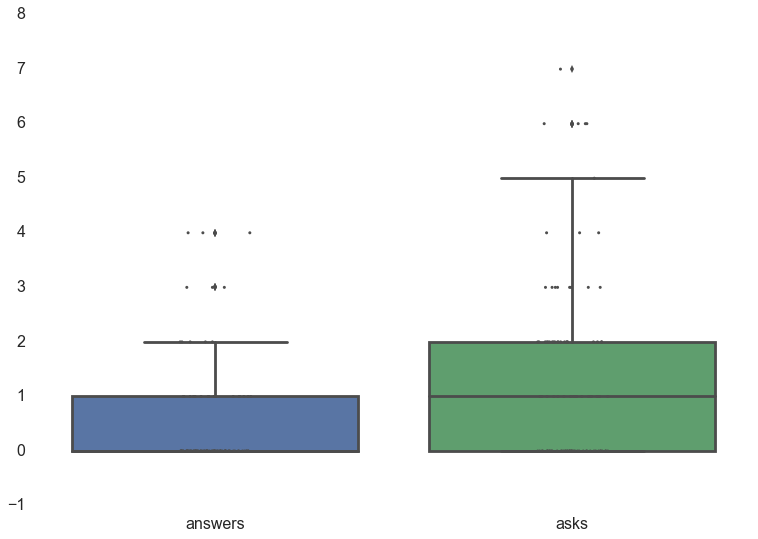

In [139]:
# Draw a nested boxplot to show bills by day and sex
# Plot the orbital period with horizontal boxes
ax = sns.boxplot(data=dfs[dfs.posts < 200].ix[:, ['answers', 'asks']])
sns.stripplot(data=dfs[dfs.posts < 200].ix[:, ['answers', 'asks']],
               jitter=True, size=3, color=".3", linewidth=0)

In [140]:
dfs_2 = dfs.dropna(how='any')

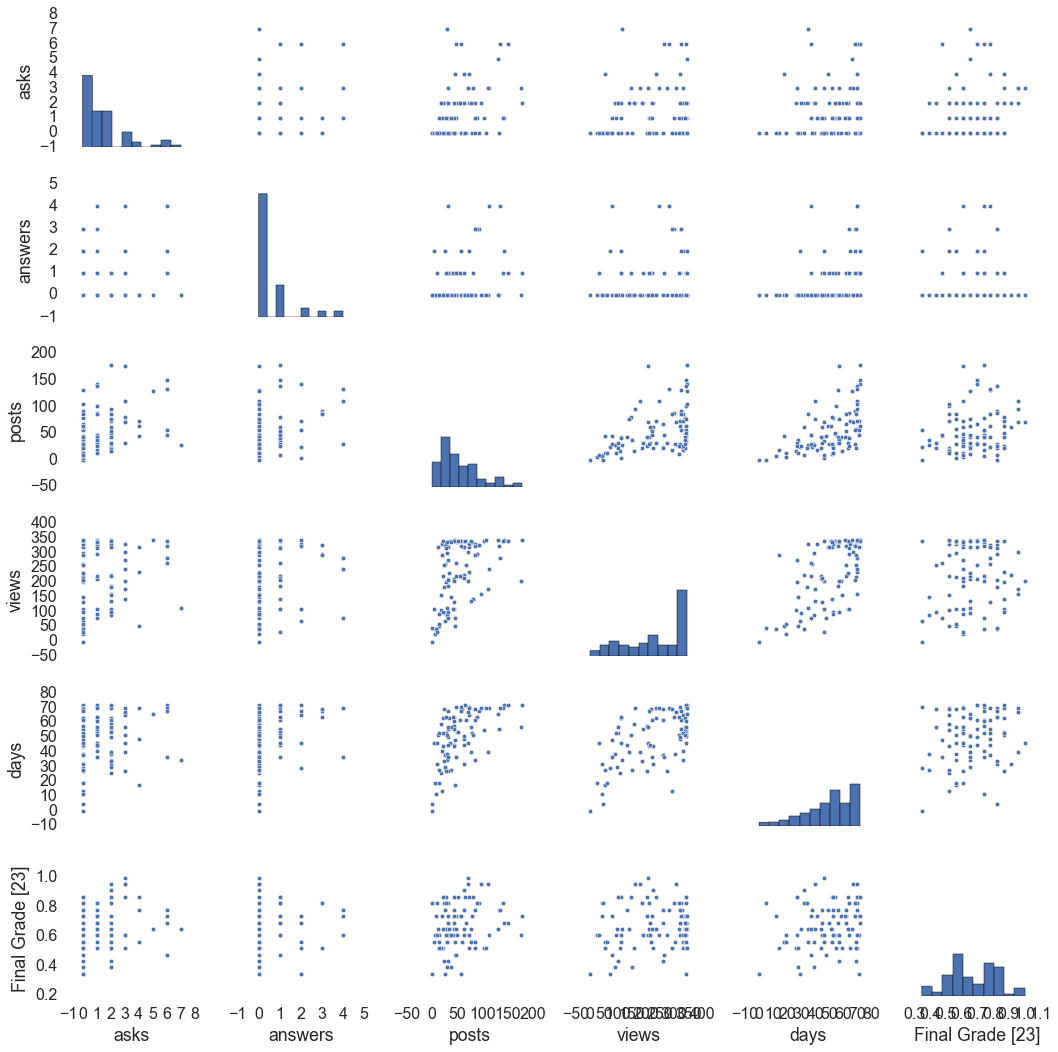

In [142]:
sns.pairplot(dfs_2[dfs_2.posts < 200]) 
# ax.add_legend(label_order = ['0','-1','-2'])

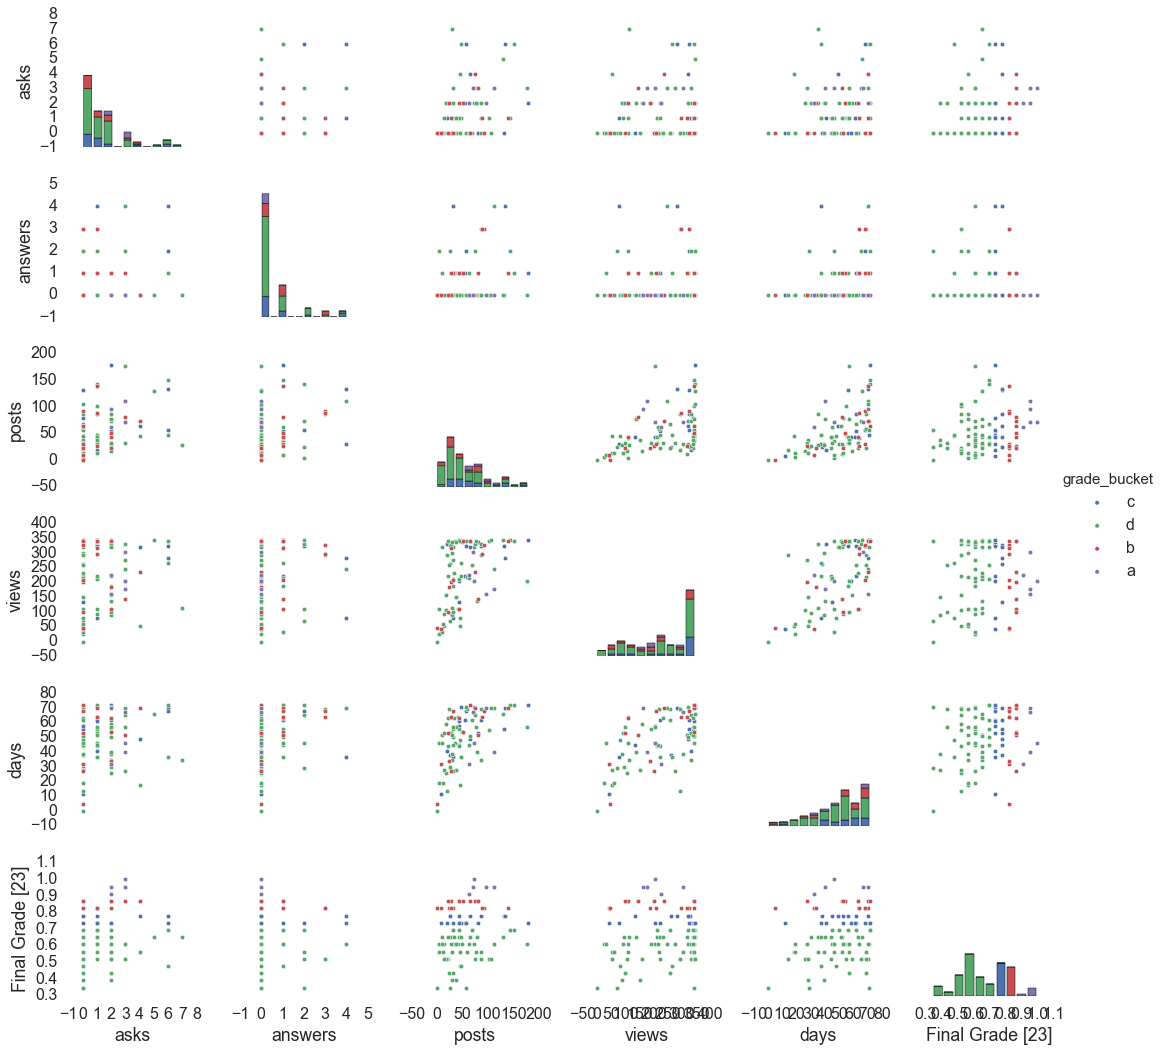

In [143]:
ax = sns.pairplot(dfs_2[dfs_2.posts < 200], hue='grade_bucket') 
# ax.add_legend(label_order = ['0','-1','-2'])

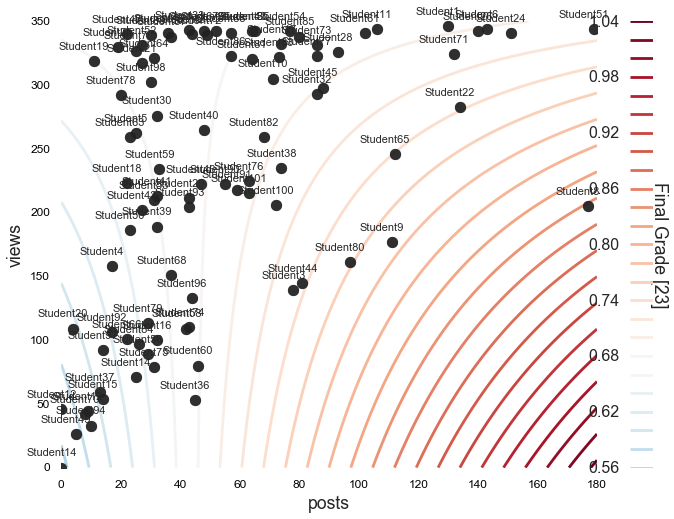

In [146]:
#plotting - Continuous interactions
# add student_id label
dfs_3 = dfs_2[dfs_2.posts < 200]

uid_labels = list(dfs_2[dfs_2.posts < 200].uid)
#sns.set_style("whitegrid")
sns.set_context("poster")

g = sns.interactplot("posts", "views", "Final Grade [23]", dfs_3)

# remove the top and right line in graph
sns.despine()

# Set the size of the graph from here
g.figure.set_size_inches(12,8)
# Set the Title of the graph from here
#g.axes.set_title('2015EduTech: Interactions Btw Students Posts, Views, Asks', 
#                 fontsize=18,color="black",alpha=0.5)
# Set the ticklabel size and color of the graph from here
g.tick_params(labelsize=12,labelcolor="black")

for label, x, y, z in zip(dfs_3.uid, dfs_3.posts, dfs_3.views, dfs_3['Final Grade [23]']):
    g.annotate(
        label, 
        fontsize=11,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'center', va = 'bottom'
        #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
    )

In [18]:
#For each user record there are the following attributes
# lti_id, user_id, asks, answers, posts, views, days
# Takes too long
# user_records = []
# for uid in y.records.findAll('user_id'):
#     for ask in y.records.findAll('asks'):
#         for ans in y.records.findAll('answers'):
#             for p in y.records.findAll('posts'):
#                 for v in y.records.findAll('views'):
#                     for d in y.records.findAll('views'):
#                         user_records.append({'user_id': uid.contents, 
#                                              'asks': ask.contents,
#                                              'answers':ans.contents, 
#                                              'posts': p.contents,
#                                              'views': v.contents,
#                                              'days': d.contents})
